# Simulating Tidal Streams from GCs Bound Initially to Satellite Galaxy TucanaIII

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt
%matplotlib notebook
import copy

from astropy import units 
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as mw
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.util.bovy_coords import rect_to_cyl, rect_to_cyl_vec
from galpy.potential import DehnenSmoothWrapperPotential
from galpy.potential import ChandrasekharDynamicalFrictionForce
from galpy.potential import MovingObjectPotential
from galpy.df import streamdf
from streamtools.df import streamspraydf
from astropy.constants import kpc

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
# Import orbits for Milky Way's satellite galaxies
satellite_gal = Orbit.from_name('MWsatellitegalaxies') #list of satellite galaxies of Milky Way 
name_satellite_gal = satellite_gal.name

## Purpose: Create a function to plot tidal streams formed by disruption of GC from a given satellite galaxy of the Milky Way

In [3]:

def plot_tidalstreams(sat_galaxy, name_sat, sat_potential, xaxis, yaxis, sat_mass, sat_size, x_satgal,y_satgal, z_satgal,
                      vx_satgal,vy_satgal, vz_satgal, tform, tsteady, cluster_mass, pre_tform, post_tform, unbound_time=None):
    
    # Function models the tidal streams formed from GC initially bound to MW satellite and later accreted onto galaxy
    #
    # Input:
    # sat_galaxy: an orbit object for a given satellite galaxy of the MW
    # name_sat: string of the satellite galaxy's name
    # sat_potential: potential object modelling the satellite's potential
    # x and y axis dimensions to plot in (strings)
    # x_satgal, y_satgal, z_satgal: x,y,z positions of the star_cluster within the satellite galaxy's frame of reference
    # vx_satgal, vy_satgal, vz_satgal: x,y,z velocities of the star_cluster within the satellite galaxy's frame of reference
    # mass and size of satellite to model dynamical friction effects (quantities with units attached)
    # tform, tsteady: parameters of the potential, models tidal disruption of satellite galaxy (quantities w/ units attached)
    # cluster_mass: mass of globular cluster being tidally disrupted 
    # pre_tform: time quanitity (w/ units) before tform to integrate to 
    # post_tform: time quantity (w/ units) after tform to integrate to
    # unbound_time: real-time quantity w/ units attached, indicates when star cluster becomes unbound from satellite galaxy
    # 
    # Output: 
    # forward and backward integrated orbit of star cluster 
    # streamspraydf model for entire disruption of globular cluster (from beginning to current time)
    # streamspraydf model for disruption of globular cluster while bound to satellite galaxy (from beginning to approx tform)

    
    
        # 1) Integrate orbit of satellite galaxy back in time given dynamical friction effects for t_back
    t_back = 10.
    ts = numpy.linspace(0.,-t_back,1000)*units.Gyr
    cdf= ChandrasekharDynamicalFrictionForce(GMs=sat_mass, rhm = sat_size ,dens=mw)
    sat_galaxy.integrate(ts, mw+cdf)
    R_sat = sat_galaxy.R(-t_back*units.Gyr)  #cylindrical radius at time t
    vR_sat = sat_galaxy.vR(-t_back*units.Gyr) #radial velocity at time t 
    vT_sat = sat_galaxy.vT(-t_back*units.Gyr) #tangential velocity at time t 
    z_sat = sat_galaxy.z(-t_back*units.Gyr) #vertical height at time t
    vz_sat = sat_galaxy.vz(-t_back*units.Gyr) #vertical velocity at time t 
    phi_sat = sat_galaxy.phi(-t_back*units.Gyr) #azimuth at time t 
    # Rectangular coordinates and velocities
    coord = [sat_galaxy.x(-t_back*units.Gyr), sat_galaxy.y(-t_back*units.Gyr), sat_galaxy.z(-t_back*units.Gyr)]
    vcoord = [sat_galaxy.vx(-t_back*units.Gyr),sat_galaxy.vy(-t_back*units.Gyr),sat_galaxy.vz(-t_back*units.Gyr)]
    
    
        # 2) Initialize star cluster on some orbit within the satellite galaxy 
            #(specific orbit is determined by cluster's x,y,z positions & vx,vy,vz velocities)
            #Integrate orbits of star cluster and satellite galaxy forward for t_fwdr
    t_fwrd = 15.
    ts = numpy.linspace(-t_back,-t_back+t_fwrd,1000)*units.Gyr
    sat_galaxy = sat_galaxy(-t_back*units.Gyr)
    #!! sat_galaxy = Orbit(vxvv = [R_sat, vR_sat, vT_sat, z_sat, vz_sat, phi_sat],ro = 8., vo=220.)
    sat_galaxy.integrate(ts, mw + cdf)
    
    # Plot orbit of the satellite galaxy in MW frame of reference:
    ###########plt.figure(figsize=(12.,10.))
    sat_galaxy.plot(d1 =  xaxis, d2= yaxis,linestyle = ':', color = 'black', label = 'satellite galaxy') 
    
    sat_movingpot = MovingObjectPotential(sat_galaxy, sat_potential)

    # Transform from satellite galaxy's frame of reference to Milky Way Galaxy's frame of reference 
    #    (using Cartesian coordinates)
    # Rectangular coordinates of the star cluster in galactocentric frame
    x_gal = coord[0] + x_satgal
    y_gal = coord[1] + y_satgal
    z_gal = coord[2] + z_satgal
    # Velocity of the star cluster in galactocentric frame
    vx_gal = vcoord[0] + vx_satgal
    vy_gal = vcoord[1] + vy_satgal
    vz_gal = vcoord[2] + vz_satgal
    # Transform to cylindrical coordinate system: R, phi, z 
    R, phi, z = rect_to_cyl(x_gal, y_gal, z_gal)
    vR, vT, vz = rect_to_cyl_vec(vx_gal, vy_gal, vz_gal,x_gal, y_gal, z_gal, cyl = False)

    star_cluster = Orbit(vxvv = [R,vR,vT,z,vz,phi],ro = 8., vo=220.)
    star_cluster.integrate(ts, mw + sat_movingpot)
    # Plot orbit of the star cluster in MW frame of reference:
    star_cluster.plot(d1 =  xaxis, d2= yaxis, linestyle = '-', overplot = True, color = 'blue', alpha=0.6,\
                      label = 'star cluster') 
    plt.title('Orbit of Star Cluster Within ' + name_sat + ' in Galactocentric Frame')
    plt.legend()
    plt.show()
    ###########plt.close()
    

        # 3) Implement wrapper potential to simulate tidal disruption of satellite galaxy's potential
            #Re-integrate orbit of star cluster within modified sat_galaxy potential 
    # Plot orbit of the satellite galaxy and star cluster within sat galaxy in MW frame of reference:
    ###########plt.figure(figsize=(12.,10.))
    tstart = tform - pre_tform
    tend = tform + post_tform
    time_int = numpy.linspace(tstart.to_value(units.Gyr), tend.to_value(units.Gyr), 1000)*units.Gyr
    
    if tstart < -t_back*units.Gyr:
            # re-integrate satellite galaxy from current time back to tstart 
            re_time = numpy.linspace(-t_back, tstart.to_value(units.Gyr), 1000)*units.Gyr
            sat_galaxy.integrate(re_time, mw+cdf)
            
            # initialize star cluster on orbit in satellite galaxy at time tstart:
            # Rectangular coordinates and velocities
            coord = [sat_galaxy.x(tstart), sat_galaxy.y(tstart), sat_galaxy.z(tstart)]
            vcoord = [sat_galaxy.vx(tstart),sat_galaxy.vy(tstart),sat_galaxy.vz(tstart)]

            # Transform from satellite galaxy's frame of reference to Milky Way Galaxy's frame of reference (using Cartesian coordinates)
            # Rectangular coordinates of the star cluster in galactocentric frame
            x_gal = coord[0] + x_satgal
            y_gal = coord[1] + y_satgal
            z_gal = coord[2] + z_satgal
            # Velocity of the star cluster in galactocentric frame
            vx_gal = vcoord[0] + vx_satgal
            vy_gal = vcoord[1] + vy_satgal
            vz_gal = vcoord[2] + vz_satgal
            # Transform to cylindrical coordinate system: R, phi, z 
            R, phi, z = rect_to_cyl(x_gal, y_gal, z_gal)
            vR, vT, vz = rect_to_cyl_vec(vx_gal, vy_gal, vz_gal,x_gal, y_gal, z_gal, cyl = False)
            
            # Re-initialize star cluster on orbit at time tstart
            star_cluster = Orbit(vxvv=[R,vR,vT,vz,z,phi], ro=8., vo=220.)
    else:
            # default: star cluster is initialized at -10Gyr in given satellite galaxy
            star_cluster = star_cluster(tstart)
    
    
    sat_galaxy = sat_galaxy(tstart) #make copy of sat_galaxy orbit at time tstart 
    sat_galaxy.integrate(time_int, mw+cdf) # integrate sat_galaxy forward for 10Gyrs
    sat_galaxy.plot(d1 =  xaxis, d2= yaxis,linestyle = ':', color = 'black', label = 'satellite galaxy')
    sat_movingpot = MovingObjectPotential(sat_galaxy, sat_potential)
    dswp = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot, tform=tform, tsteady=tsteady, decay = True)
    star_cluster.integrate(time_int, mw+dswp) 
        # star cluster in combined potential: MW galaxy & moving potential of satellite galaxy 
    star_cluster.plot(d1 =  xaxis, d2= yaxis, linestyle = '-', overplot = True, color = 'blue', alpha = 0.6,\
                      label = 'star cluster') 
        #plots orbit of the star_cluster in MW frame of reference
    plt.legend()
    plt.title('Star Cluster Orbit Within: '+name_sat+' for Tform = ' + str(tform) + ' & Tsteady = ' + str(tsteady) + ' in Galactocentric Frame')
    label='wrappedpot_orbit_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    ###########plt.close()
    
    # Figure out where star cluster is at end of integration: at tend 
    end_pos_cluster = [star_cluster.R(tend),star_cluster.vR(tend),star_cluster.vT(tend),star_cluster.z(tend),star_cluster.vz(tend), star_cluster.phi(tend)]
            # [R,vT,vT,z,vz,phi]
    end_pos_gal = [sat_galaxy.R(tend),sat_galaxy.vR(tend),sat_galaxy.vT(tend),sat_galaxy.z(tend),sat_galaxy.vz(tend), sat_galaxy.phi(tend)]

    '''
    # Used for finding dswp when integrating satellite galaxy backward in previous version of code
    time_intb = numpy.linspace(tend.to_value(units.Gyr), tstart.to_value(units.Gyr), 1000)*units.Gyr
    star_cluster_b = Orbit(vxvv = end_pos_cluster, ro=8., vo =220.) #full 6 coordinates
    sat_galaxy_b = Orbit(vxvv=end_pos_gal, ro=8., vo =220.)
    sat_galaxy_b.integrate(time_intb, mw + cdf)
    sat_galaxy_b.plot(d1 =  xaxis_dim, d2= yaxis_dim,linestyle = ':', color = 'black', label = 'satellite galaxy')
    sat_movingpot_b = MovingObjectPotential(sat_galaxy_b, sat_potential)
    #new_tform = tform - end_t
    #dswp_back = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot_b, tform=tform, tsteady=tsteady, decay = True)
    star_cluster_b.integrate(time_intb, mw + dswp) # star cluster is in combined potential of MW galaxy and the moving potential of satellite galaxy 
    star_cluster_b.plot(d1 =  xaxis_dim, d2= yaxis_dim, linestyle = '-', overplot = True, color = 'blue', alpha = 0.6,\
                      label = 'star cluster') # galactocentric radius as a function of time
    plt.legend()
    plt.title('Orbit of Star Cluster Within Satellite Galaxy for Tform = ' + str(tform) + ' & Tsteady = ' + str(tsteady) + ' (in Galactocentric Frame)')
    plt.show()
    plt.close()
    '''
    
    
    '''
    ts_b = numpy.linspace(0.,-end_t.to_value(units.Gyr),1000)*units.Gyr
    #!!star_cluster_b = Orbit(vxvv = end_pos_cluster, ro=8., vo =220.) #full 6 coordinates
    sat_galaxy_b = Orbit(vxvv=end_pos_gal, ro=8., vo =220.)
    sat_galaxy_b.integrate(ts_b, mw + cdf)
    sat_movingpot_b = MovingObjectPotential(sat_galaxy_b, sat_potential)
    tform_b = tform - end_t
    dswp_b = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot_b, tform=tform_b, tsteady=tsteady, decay = True)
    '''

    
         # 4) Model tidal streams formed by disruption of globular cluster with given cluster_mass and cluster orbit from #3
        
    cluster_orbit = Orbit(vxvv=end_pos_cluster, ro=8., vo=220.)
    
    # Integrate orbit of star cluster (progenitor) both forwards and backwards for 100 Myr
    ts = numpy.linspace(tend.to_value(units.Gyr),100., 1000)*units.Myr
    cluster_orbit.integrate(ts, mw + dswp)
    cluster_orbitb = cluster_orbit()
    cluster_orbitb.integrate(-ts, mw + dswp)
    cluster_orbit.turn_physical_off()
    #!!!cluster_orbitb.turn_physical_off()
    
    # Re-integrate orbit of sat galaxy to match disruption time and re-implement moving potential to model satellite galaxy
    t_disrupt = tend - tstart
    ts = numpy.linspace(0., -t_disrupt.to_value(units.Gyr), 1000)*units.Gyr
    sat_galaxy_tidal = Orbit(vxvv=end_pos_gal)
    sat_galaxy_tidal.integrate(ts, mw + cdf)
    sat_movingpot = MovingObjectPotential(sat_galaxy_tidal, sat_potential)
    tform_new = tform - tend
    dswp_new = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot, tform=tform_new, tsteady=tsteady, decay = True)

    # Model leading part of the stream
    spdf= streamspraydf(cluster_mass,progenitor=cluster_orbit,pot=dswp_new+mw, rtpot=mw, leading=True, tdisrupt=t_disrupt)
    # Model trailing part of the tidal stream
    spdft= streamspraydf(cluster_mass,progenitor=cluster_orbit,pot=dswp_new+mw, rtpot=mw, leading=False,tdisrupt=t_disrupt)

    # Comparing streamspraydf progenitor's orbit to cluster orbit integrated with wrapped potential of sat_galaxy + milkyway
    o = copy.deepcopy(spdf._progenitor)
    o.turn_physical_on()
    o.plot(d1='t',d2='r', color = 'pink', label= 'Progenitor Orbit from Streamspray')

    ts = numpy.linspace(0.,-t_disrupt.to_value(units.Gyr),1000)*units.Gyr
    cluster_o = Orbit(vxvv=end_pos_cluster, ro=8., vo=220.)
    cluster_o.integrate(ts, dswp_new+mw)
    cluster_o.plot(d1='t',d2='r',linestyle = ':', overplot = True, color = 'black',\
                   label='Manually Integrated Cluster Orbit')
    plt.legend()
    plt.title('Comparing Orbit from Streamspray to Manually Integrated Orbit of Star Cluster')
    plt.show()
    ###########plt.close()
    
    o.plot(color = 'pink', label='Progenitor Orbit from Streamspray')
    cluster_o.plot(linestyle=':', color='black',overplot=True, label='Manually Integrated Cluster Orbit')
    plt.legend()
    plt.title('Comparing Orbit from Streamspray to Manually Integrated Orbit of Star Cluster')
    plt.show()
    ###########plt.close()

    # Plot orbit of progenitor
    ###########plt.figure(figsize=(16.,12.))
    cluster_orbit.turn_physical_on()
    cluster_orbitb.turn_physical_on()
    cluster_orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
    cluster_orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    # spdf.sample returns: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
    RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
    RvRt,dtt= spdft.sample(n=300,returndt=True,integrate=True)
    
    # Convert from natural units to physical units
    d = 8.
    plt.plot(cluster_orbit.R(),cluster_orbit.z(),'o', color='orange')
    plt.plot(RvR[0]*d,RvR[3]*d,'r.', label = 'leading', alpha= 0.6)
    plt.plot(RvRt[0]*d,RvRt[3]*d,'b.', label = 'trailing', alpha= 0.6)
    plt.legend()
    '''
    xmin = [min(RvR[0]*d), min(RvRt[0]*d)]
    xmax = [max(RvR[0]*d), max(RvRt[0]*d)]
    xlim = (min(xmin), max(xmax))
    ymin = [min(RvR[3]*d), min(RvRt[3]*d)]
    ymax = [max(RvR[3]*d), max(RvRt[3]*d)]
    ylim = (min(ymin), max(ymax))
    plt.xlim(xlim)
    plt.ylim(ylim)
    '''
    plt.title('Tidal Disruption of GC Initially Bound to: ' + name_sat + ' from '+ str(tstart)+' to '+str(tend))
    #plt.title('Tidal Disruption for '+ str(t_disrupt)+' of GC Initially Bound to: ' + name_sat )
    label='tidalstream_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    #plt.close()
    
    '''
        # 5) Plot tidal stream using colormap to indicate the time since the star was stripped from cluster (using dt)
    from astropy.constants import kpc
    
    cluster_orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
    cluster_orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    # Implement colormap and colorscale using dt
    v=220.
    sec_in_Gyr = 3.16e16
    t_Gyr= (d*kpc)/(v*1e3)/sec_in_Gyr #converts from natural units to Gyr
    amp = dt*t_Gyr
    plt.scatter(RvR[0]*d,RvR[3]*d, label = 'leading', c=amp, cmap = 'Reds' )
    plt.colorbar(label='Time Since Stripping (Gyr)')
    ampt = dtt*t_Gyr
    plt.scatter(RvRt[0]*d,RvRt[3]*d, label = 'trailing', c=ampt, cmap = 'Blues' )
    plt.colorbar()
    plt.plot(orbit.R(),orbit.z(),'o', color='orange')
    #plt.legend()
    label='tidalstreams:'+name_sat+'.pdf'
    plt.title('Tidal Disruption of GC Initially Bound to: ' + name+ ' for '+ str(t_disrupt))
    plt.savefig(label)
    plt.show()
    plt.close()
    
    '''
    
    

     # 5) Create a new streamspraydf object to model only those stars stripped while cluster is bound to satellite galaxy
    
    if unbound_time == None:
        unbound_time = tform #default value for unbound time
        
    tend = unbound_time
    diff = tform - tend
    
    # Figure out where star cluster is at end of integration: at tend 
    end_pos_cluster = [star_cluster.R(tend),star_cluster.vR(tend),star_cluster.vT(tend),star_cluster.z(tend),\
                       star_cluster.vz(tend),star_cluster.phi(tend)]
            # [R,vT,vT,z,vz,phi]
    end_pos_gal = [sat_galaxy.R(tend),sat_galaxy.vR(tend),sat_galaxy.vT(tend),sat_galaxy.z(tend),sat_galaxy.vz(tend),\
                   sat_galaxy.phi(tend)]
            
    cluster_orbit_bound = Orbit(vxvv=end_pos_cluster, ro=8., vo=220.) 
    
    # Integrate orbit of star cluster (progenitor) both forwards and backwards for 100 Myr
    ts = numpy.linspace(tend.to_value(units.Gyr),100., 1000)*units.Myr
    cluster_orbit_bound.integrate(ts, mw + dswp)
    cluster_orbitb_bound = cluster_orbit_bound()
    cluster_orbitb_bound.integrate(-ts, mw + dswp)
    cluster_orbit_bound.turn_physical_off()
    cluster_orbitb_bound.turn_physical_off()
    
    
    # Re-integrate orbit of sat galaxy to match disruption time and re-implement moving potential to model satellite galaxy
    t_disrupt = tend - tstart
    ts = numpy.linspace(0., -t_disrupt.to_value(), 1000)*units.Gyr
    sat_galaxy_tidal = Orbit(vxvv=end_pos_gal)
    sat_galaxy_tidal.integrate(ts, mw + cdf)
    sat_movingpot = MovingObjectPotential(sat_galaxy_tidal, sat_potential)
    tform_new = diff
    dswp_new = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot, tform=tform_new, tsteady=tsteady, decay = True)
                   
    # Model leading part of the stream
    spdf_bound= streamspraydf(cluster_mass,progenitor=cluster_orbit_bound,pot=dswp_new+mw, rtpot=mw,\
                              leading=True, tdisrupt=t_disrupt)
    # Model trailing part of the tidal stream
    spdft_bound= streamspraydf(cluster_mass,progenitor=cluster_orbit_bound,pot=dswp_new+mw, rtpot=mw,\
                               leading=False,tdisrupt=t_disrupt)
    
    # Plot orbit of progenitor
    ###########plt.figure(figsize=(16.,12.))
    cluster_orbit_bound.turn_physical_on()
    cluster_orbitb_bound.turn_physical_on()
    cluster_orbit_bound.plot(d1 = 'R', d2 = 'z', color = 'k')
    cluster_orbitb_bound.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    # spdf.sample returns: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
    RvR,dt= spdf_bound.sample(n=300,returndt=True,integrate=True)
    RvRt,dtt= spdft_bound.sample(n=300,returndt=True,integrate=True)
    
    # Convert from natural units to physical units
    plt.plot(RvR[0]*d,RvR[3]*d,'r.', label = 'leading')
    plt.plot(RvRt[0]*d,RvRt[3]*d,'b.', label = 'trailing')
    plt.plot(cluster_orbit_bound.R(),cluster_orbit_bound.z(),'o', color='orange')
    plt.legend()
    plt.title('Tidal Disruption of GC Initially Bound to: ' + name_sat + ' from '+ str(tstart)+' to '+str(tend))
    label='tidalstream_bound2sat_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    ###########plt.close()
    
    

        # 6) Create a new streamspraydf object to model only those stars stripped after cluster is bound to MW galaxy
    
    if unbound_time == None:
        unbound_time = tform #default value for unbound time
        
    tstart = unbound_time
    tend = tform + post_tform
    diff = tform - tend #tend becomes 0 in streamspraydf model so tform is negative 
    
    # Figure out where star cluster is at end of integration: at tend 
    end_pos_cluster = [star_cluster.R(tend),star_cluster.vR(tend),star_cluster.vT(tend),star_cluster.z(tend),\
                       star_cluster.vz(tend),star_cluster.phi(tend)]
            # [R,vT,vT,z,vz,phi]
    end_pos_gal = [sat_galaxy.R(tend),sat_galaxy.vR(tend),sat_galaxy.vT(tend),sat_galaxy.z(tend),sat_galaxy.vz(tend),\
                   sat_galaxy.phi(tend)]
            
    cluster_orbit_bound = Orbit(vxvv=end_pos_cluster, ro=8., vo=220.) 
    
    # Integrate orbit of star cluster (progenitor) both forwards and backwards for 100 Myr
    ts = numpy.linspace(tend.to_value(units.Gyr),100., 1000)*units.Myr
    cluster_orbit_bound.integrate(ts, mw + dswp)
    cluster_orbitb_bound = cluster_orbit_bound()
    cluster_orbitb_bound.integrate(-ts, mw + dswp)
    cluster_orbit_bound.turn_physical_off()
    cluster_orbitb_bound.turn_physical_off()
    
    
    # Re-integrate orbit of sat galaxy to match disruption time and re-implement moving potential to model satellite galaxy
    t_disrupt = tend - tstart
    ts = numpy.linspace(0., -t_disrupt.to_value(), 1000)*units.Gyr
    sat_galaxy_tidal = Orbit(vxvv=end_pos_gal)
    sat_galaxy_tidal.integrate(ts, mw + cdf)
    sat_movingpot = MovingObjectPotential(sat_galaxy_tidal, sat_potential)
    tform_new = diff
    dswp_new = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot, tform=tform_new, tsteady=tsteady, decay = True)
                   
    # Model leading part of the stream
    spdf_unbound= streamspraydf(cluster_mass,progenitor=cluster_orbit_bound,pot=dswp_new+mw, rtpot=mw,\
                              leading=True, tdisrupt=t_disrupt)
    # Model trailing part of the tidal stream
    spdft_unbound= streamspraydf(cluster_mass,progenitor=cluster_orbit_bound,pot=dswp_new+mw, rtpot=mw,\
                               leading=False,tdisrupt=t_disrupt)
     
    # Plot orbit of progenitor
    ###########plt.figure(figsize=(16.,12.))
    cluster_orbit_bound.turn_physical_on()
    cluster_orbitb_bound.turn_physical_on()
    cluster_orbit_bound.plot(d1 = 'R', d2 = 'z', color = 'k')
    cluster_orbitb_bound.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    # spdf.sample returns: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
    RvR,dt= spdf_unbound.sample(n=300,returndt=True,integrate=True)
    RvRt,dtt= spdft_unbound.sample(n=300,returndt=True,integrate=True)
    
    # Convert from natural units to physical units
    plt.plot(RvR[0]*d,RvR[3]*d,'r.', label = 'leading')
    plt.plot(RvRt[0]*d,RvRt[3]*d,'b.', label = 'trailing')
    plt.plot(cluster_orbit_bound.R(),cluster_orbit_bound.z(),'o', color='orange')
    plt.legend()
    plt.title('Tidal Disruption of GC Initially Bound to: ' + name_sat + ' from '+ str(tstart)+' to '+str(tend))
    label='tidalstream_bound2sat_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    ###########plt.close()
    
    return spdf, spdft, cluster_orbit, cluster_orbitb, spdf_bound, spdft_bound, cluster_orbit_bound, cluster_orbitb_bound
    
    




def zoom(orbit, orbitb, spdf, spdft, xlim, ylim, name_sat):
    
    # Function zooms into tidal streams plot by specifying xlim & ylim near current position of cluster 
    #
    # Input:
    # orbit: previously integrated orbit for star cluster, forward in time 
    # orbitb: previously integrated orbit for star cluster, backward in time 
    # spdf: streamspraydf object for tidal stream, leading part
    # spdft: streamspraydf object for tidal stream, trailing part
    # xlim: (smaller, larger) limits of x-axis
    # ylim: (smaller, larger) limits of y-axis
    # name_sat: name of satellite galaxy
    # 
    # Output: 
    # 
    
    # Plot orbit of progenitor
    plt.figure(figsize=(18.,12.))
    orbit.turn_physical_on()
    orbitb.turn_physical_on()
    orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
    orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    # Return: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
    RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
    RvRt,dt= spdft.sample(n=300,returndt=True,integrate=True)
    # Convert from natural units to physical units
    d = 8.*units.kpc
    plt.plot(RvR[0]*d,RvR[3]*d,'r.', label = 'leading')
    plt.plot(RvRt[0]*d,RvRt[3]*d,'b.', label = 'trailing')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(orbit.R(),orbit.z(),'o', color='orange');
    plt.legend()
    v = 220.*units.km/units.s
    sec_in_Gyr = 3.16e16*units.s
    t_Gyr= ( ( (d.to_value(units.m)*units.m) / (v.to_value(units.m/units.s)*units.m/units.s) ) /sec_in_Gyr)*units.Gyr #converts from natural units to Gyr
    time_disrupt = numpy.rint((spdf._tdisrupt*t_Gyr).to_value(units.Gyr))
    plt.title('Tidal Disruption of GC Initially Bound to: ' + name_sat +' for '+ str(time_disrupt) + ' Gyr')
    label='tidalstream_zoom_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    plt.close()
    

    
def plot_colormap(orbit, orbitb, spdf, spdft, xlim, ylim, name_sat):
    
    # Function plots tidal stream using colormap to indicate time since stripping from cluster (using dt) & zooms into plot
    # 
    # Input:
    # orbit: previously integrated orbit for star cluster, forward in time 
    # orbitb: previously integrated orbit for star cluster, backward in time 
    # spdf: streamspraydf object for tidal stream, leading part
    # spdft: streamspraydf object for tidal stream, trailing part
    # xlim: (smaller, larger) limits of x-axis
    # ylim: (smaller, larger) limits of y-axis
    # name_sat: name of satellite galaxy
    # 
    # Output: 
    # 
    

    # Plot orbit of progenitor
    plt.figure(figsize=(18.,12.))
    orbit.turn_physical_on()
    orbitb.turn_physical_on()
    orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
    orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    # spdf.sample returns: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
    RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
    RvRt,dtt= spdft.sample(n=300,returndt=True,integrate=True)

    # Implement colormap and colorscale using dt
    d = 8.*units.kpc
    v = 220.*units.km/units.s
    sec_in_Gyr = 3.16e16*units.s
    t_Gyr= ( ( (d.to_value(units.m)*units.m) / (v.to_value(units.m/units.s)*units.m/units.s) ) /sec_in_Gyr)*units.Gyr
        #converts from natural units to Gyr

    amp = dt*t_Gyr
    plt.scatter(RvR[0]*d,RvR[3]*d, label = 'leading', c=amp, cmap = 'Reds' )
    plt.colorbar(label='Time Since Stripping (Gyr)')
    ampt = dtt*t_Gyr
    plt.scatter(RvRt[0]*d,RvRt[3]*d, label = 'trailing', c=ampt, cmap = 'Blues' )
    plt.colorbar()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(orbit.R(),orbit.z(),'o', color='orange')
    #plt.legend()
    time_disrupt = numpy.rint((spdf._tdisrupt*t_Gyr).to_value(units.Gyr))
    plt.title('Tidal Disruption of GC Initially Bound to: ' + name_sat+ ' for '+ str(time_disrupt)+' Gyr')
    label='tidalstream_colormap_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    plt.close()
    
    
def test_cocoon(orbit, orbitb, spdf, spdft, xlim, ylim, name_sat, tstart, tend, tform, end_strip = None):
    
    # Function uses dt,dtt to see only stars that escaped while globular cluster was still bound to satellite galaxy
    # 
    # Input:
    # orbit: previously integrated orbit for star cluster, forward in time 
    # orbitb: previously integrated orbit for star cluster, backward in time 
    # spdf: streamspraydf object for tidal stream, leading part
    # spdft: streamspraydf object for tidal stream, trailing part
    # xlim: (smaller, larger) limits of x-axis
    # ylim: (smaller, larger) limits of y-axis
    # end_time: quantity (in units of Gyr) indicating time at which stripping is stopped 
    # name_sat: name of satellite galaxy
    # tstart: quantity (in units of Gyr) indicating time which corresponds to start of stripping time
    # tend: quantity (in units of Gyr) indicating time which corresponds to end of stripping time
    # tform: quantity (in units of Gyr) indicating time at which satellite galaxy begins tidally disrupting 
    # end_strip: quantity (in units of Gyr) indicating real-time at which stripping is stopped, default: tform 
    #
    # Output: 
    # 

    # spdf.sample returns: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
    RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
    RvRt,dtt= spdft.sample(n=300,returndt=True,integrate=True)
    
    dt_new = numpy.copy(dt)
    dtt_new= numpy.copy(dtt)
    
    d = 8.*units.kpc
    v = 220.*units.km/units.s
    sec_in_Gyr = 3.16e16*units.s
    t_Gyr= ( ( (d.to_value(units.m)*units.m) / (v.to_value(units.m/units.s)*units.m/units.s) ) /sec_in_Gyr)*units.Gyr
    total_time = tend - tstart 
    if end_strip == None:
        end_strip = tform 

    end_strip_new = end_strip - tstart # convert from real-time to strip time: indicates time after tstart at which stripping ends 
    endtime_since = total_time - end_strip_new # time since star was stripped 
    
    # Delete items in arrays according to time for both leading and trailing star samples from spdf objects
    indices = numpy.where(dt_new*t_Gyr < endtime_since) # convert time from natural units to Gyr
    dt_new = dt_new[dt_new*t_Gyr >= endtime_since]
    new_sample_num = len(dt_new)
    RvR_new=numpy.empty((6, new_sample_num))
    for index in range(6):
        RvR_new[index] = numpy.delete(RvR[index], indices)
        
    indices = numpy.where(dtt_new*t_Gyr < endtime_since) # convert time from natural units to Gyr 
    dtt_new = dtt_new[dtt_new*t_Gyr >= endtime_since]
    new_sample_num = len(dtt_new)
    RvRt_new = numpy.empty((6, new_sample_num))
    for index in range(6):
        RvRt_new[index] = numpy.delete(RvRt[index], indices)
    
        # PLOT 1: Colormap 
    # Plot orbit of progenitor
    plt.figure(figsize=(24.,16.))
    orbit.turn_physical_on()
    orbitb.turn_physical_on()
    orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
    orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)


    # Implement colormap and colorscale using dt
    amp = dt_new*t_Gyr
    plt.scatter(RvR_new[0]*d,RvR_new[3]*d, label = 'leading', c=amp, cmap = 'Reds' )
    plt.colorbar(label='Time Since Stripping (Gyr)')
    ampt = dtt_new*t_Gyr
    plt.scatter(RvRt_new[0]*d,RvRt_new[3]*d, label = 'trailing', c=ampt, cmap = 'Blues' )
    plt.colorbar()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(orbit.R(),orbit.z(),'o', color='orange')
    plt.title('Stars Stripped from '+ str(tstart)+ ' to '+ str(end_strip)+' from GC Initially Bound to: ' + name_sat)
    label='tidalstream_cocoon_colormap_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    plt.close()
    
    
        # PLOT 2: No colorscale 
    # Plot orbit of progenitor
    plt.figure(figsize=(24.,16.))
    orbit.turn_physical_on()
    orbitb.turn_physical_on()
    orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
    orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

    plt.plot(RvR_new[0]*d,RvR_new[3]*d,'r.', label = 'leading')
    plt.plot(RvRt_new[0]*d,RvRt_new[3]*d,'b.', label = 'trailing')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(orbit.R(),orbit.z(),'o', color='orange');
    plt.legend()
    plt.title('Stars Stripped from '+ str(tstart)+ ' to '+ str(end_strip)+' from GC Initially Bound to: ' + name_sat)
    label='tidalstream_cocoon_'+name_sat+'.pdf'
    plt.savefig(label, bbox_inches="tight")
    plt.show()
    plt.close()
    

    return RvR_new,RvR, dt_new, dt, RvRt_new, RvRt, dtt_new, dtt
    


TucanaIII
35.25509518429917 km / s


<IPython.core.display.Javascript object>


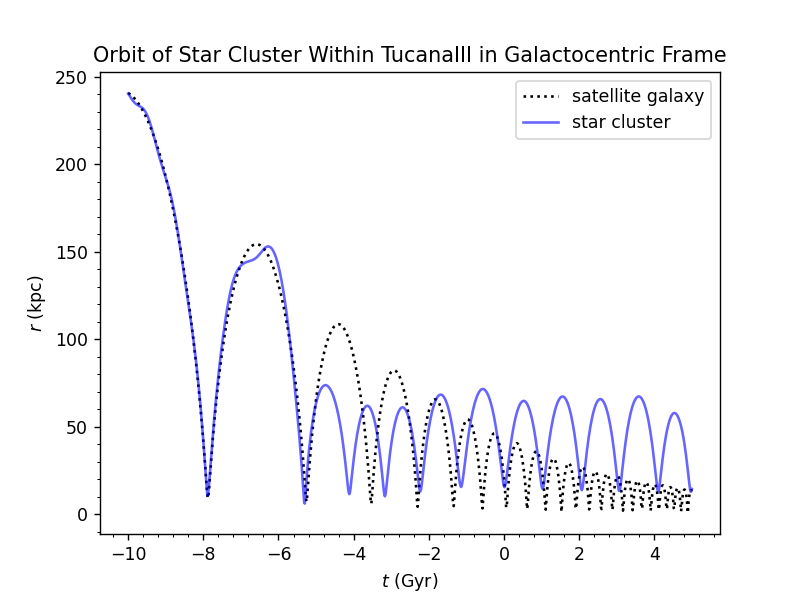

<IPython.core.display.Javascript object>


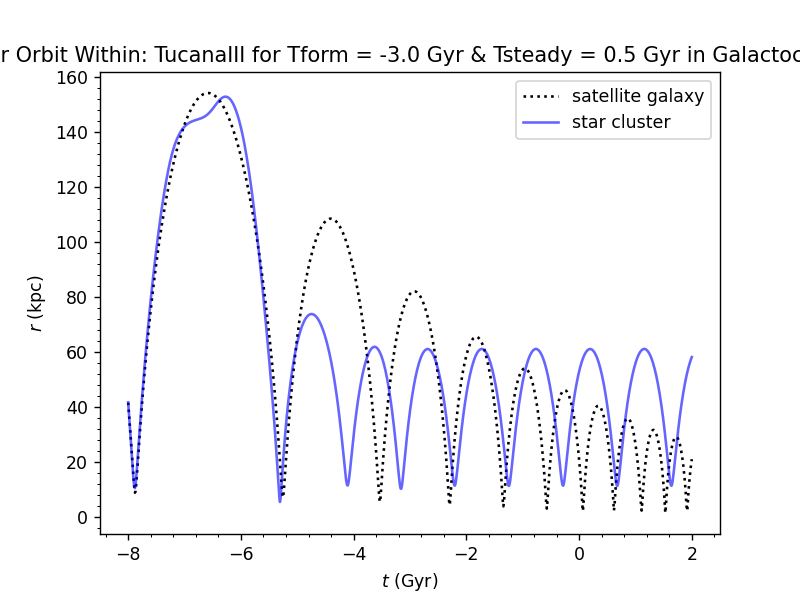

<IPython.core.display.Javascript object>


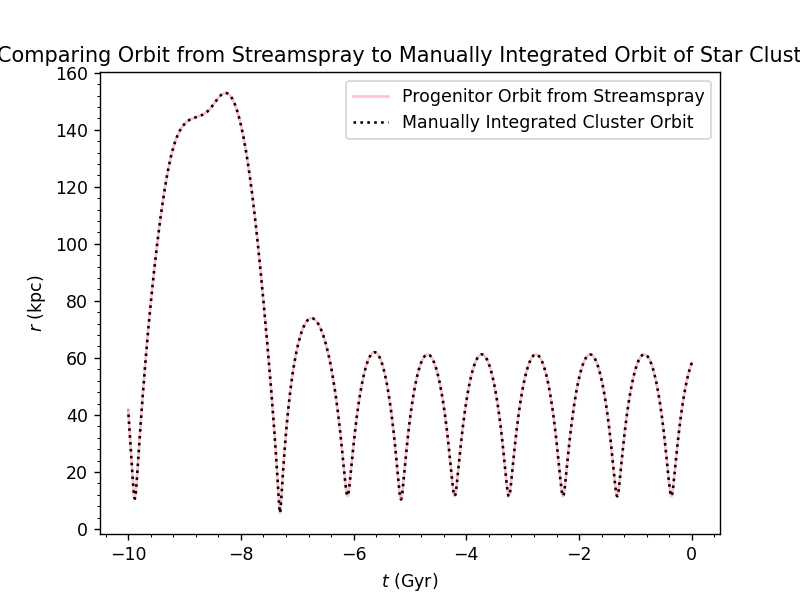

<IPython.core.display.Javascript object>


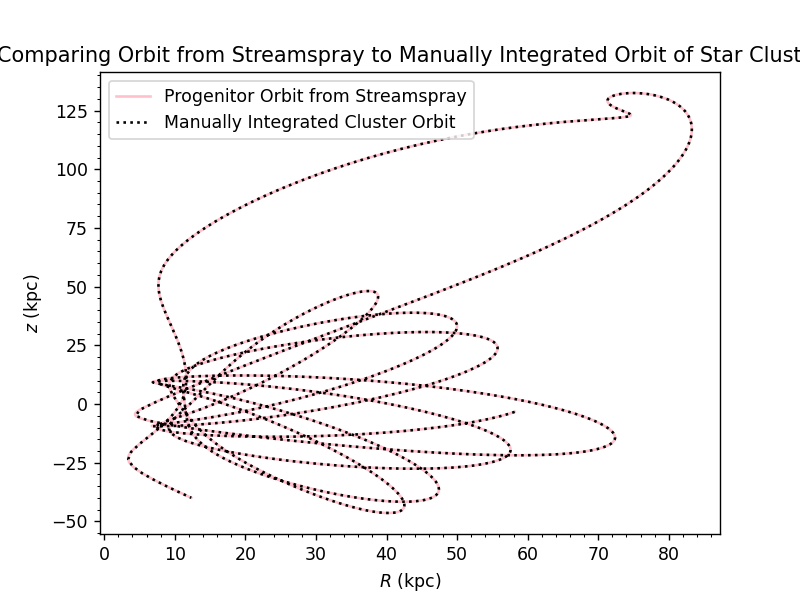

<IPython.core.display.Javascript object>


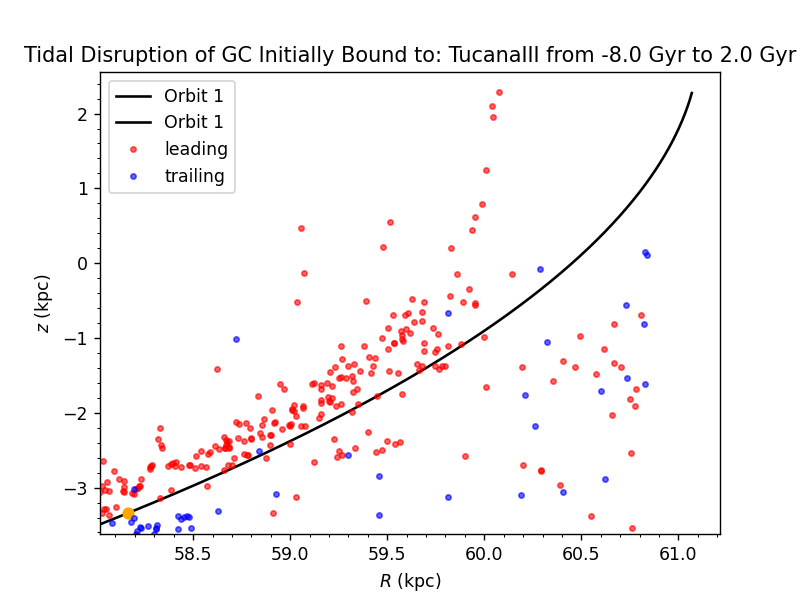

<IPython.core.display.Javascript object>


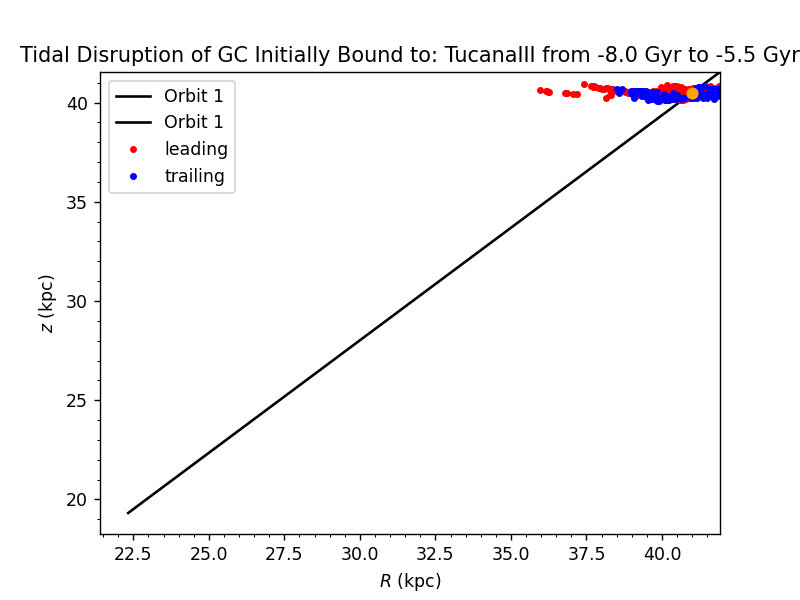

<IPython.core.display.Javascript object>


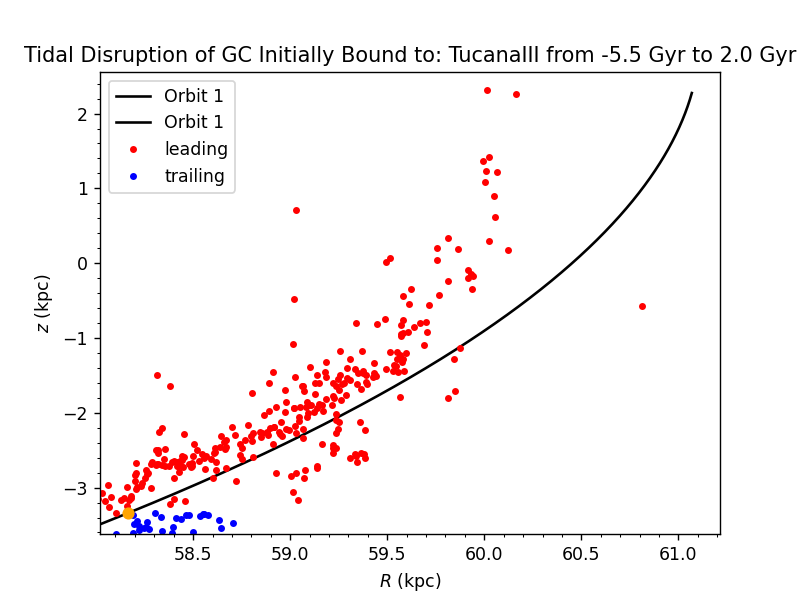

In [4]:
index = 35
sat = satellite_gal[index]
name = name_satellite_gal[index]
xaxis = 't'
yaxis = 'r'
print(name)
Msat = 10.**11.*units.Msun
size = 1.05*(Msat/(10.**8./1*units.Msun))**0.5*units.kpc
potential = HernquistPotential(amp = 2*Msat, a = size, ro = 8., vo=220.)
x,y,z = 4*units.kpc, 0*units.kpc, 0*units.kpc
vcirc = potential.vcirc(4*units.kpc)
vx, vy, vz = 0.*units.km/units.s, vcirc, 0.*units.km/units.s
print(vcirc)
tform, tsteady = -3.*units.Gyr, 0.5*units.Gyr #timescale for tidal disruption of satellite galaxy
Mcluster = 2e4*units.Msun
unboundt = -5.5*units.Gyr # time at which star cluster becomes unbound from satellite galaxy
pre_tform = 5*units.Gyr
post_tform = 5*units.Gyr

spdf, spdft, cluster_orbit, cluster_orbitb, spdf_bound, spdft_bound, cluster_orbit_bound, cluster_orbitb_bound\
=plot_tidalstreams(sat, name, potential,xaxis, yaxis, Msat, size, x,y,z,vx,vy,vz,tform,tsteady, Mcluster,pre_tform, post_tform,unbound_time = unboundt)




In [ ]:
a = numpy.array([5,4,3])
b = numpy.array([1,19,87])
new = [max(a),max(b)]
max(new)


In [ ]:
xlim= (56,60)
ylim= (-8,2)
zoom(cluster_orbit, cluster_orbitb, spdf, spdft, xlim, ylim, name)
plot_colormap(cluster_orbit, cluster_orbitb, spdf, spdft, xlim, ylim, name)

In [ ]:
tstart, tend = tform - 5.*units.Gyr, tform + 5*units.Gyr
'''
xlim= (50,60)
ylim= (-15,0)
'''
xlim= (56,60)
ylim= (-8,2)
RvR_new,RvR, dt_new, dt, RvRt_new, RvRt, dtt_new, dtt = test_cocoon(cluster_orbit, cluster_orbitb, spdf, spdft, xlim, ylim, 
                                                                    name,tstart, tend, tform, end_strip = unboundt)


In [ ]:
print(type(tstart))

In [ ]:
# ROUGH WORK 
print(spdf._tdisrupt)
d = 8*units.kpc
print(d.to_value(units.m))
t = 6*units.Gyr
print(t.to_value(units.Gyr))
print(t)


In [ ]:
a = [[3,4,5],[5,2,1]]
b = numpy.array([1,3,5,6,3,4,8,9,10,14,32])
b = b[b > 4]
print(b)

In [ ]:
spdf
lst_a = []

In [ ]:
lst_a.append(spdf)

In [ ]:
lst_a


In [ ]:
lst_a.append(spdft)

In [ ]:
lst_a

In [ ]:
arr = numpy.array([])
arr = numpy.append(arr, spdf)

In [ ]:
arr


In [ ]:
arr = numpy.append(arr, spdft)

In [ ]:
arr

In [ ]:
print(type(RvR[0]))

In [ ]:
vxvv
